In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from product_fem import product_fem as pf
from fenics import *

## Drift-diffusion equation with exponential analytic solution

Here we consider 

$$
\begin{align*}
    -\varepsilon\Delta u + \mathbf b \cdot \nabla u &= f \quad \mathrm{in}\, \Omega \\
    u &= 0\quad \mathrm{on} \,\partial\Omega
\end{align*}
$$

when $\mathbf{b}(x,y) = (x, y)^T$ and
$f(x,y) = \mathbf X(x) \cdot \mathbf Y(y)$
where

$$
\begin{align*}
    \mathbf X(x) &= \exp(x)(
    2\varepsilon x^2, 
    2\varepsilon x, 
    4\varepsilon x, 
    -b_1(x^2+x-1), 
    x(x-1))^T, \\
    \mathbf Y(y) &= \exp(-y)(
    (y-1)(y-2), 
    y(y-1), 
    y-1, 
    y(y-1), 
    b_2(y^2-3y+1))^T,
\end{align*}
$$

i.e. 
$$
f(x,y) = [2\varepsilon (x^2(y-1)(y-2) + xy(y-1) + 2x(y-1))
- b_1(x^2+x-1)(y-1)y 
+ b_2 x(x-1)(y^2-3y+1)]\exp(x-y),
$$

the analytic solution is $u(x,y) = -x(1-x)y(1-y)\exp(x-y)$.
As long as $\mathbf b(x,y) = (b_1(x), b_2(y))^T$
the weak solution $u_h$ satisfies $Au_h = b$ where

$$
A_{ij,k\ell} = 
\varepsilon\int\! \phi_k'\hat\phi_i' \,dx
\int\! \phi_\ell\hat\phi_j \,dy 
+
\varepsilon\int\! \phi_k\hat\phi_i \,dx
\int\! \phi_\ell'\hat\phi_j' \,dy 
+
\int\! b_1\phi_k'\hat\phi_i \,dx
\int\! \phi_\ell\hat\phi_j \,dy
+
\int\! \phi_k\hat\phi_i \,dx
\int\! b_2\phi_\ell'\hat\phi_j \,dy
$$

and $b_{ij} = \sum_k\int\! X_k\hat\phi_i \,dx \int\! Y_k\hat\phi_j \,dy$

In [4]:
def forward_solve(n, eps=1e-3, error=False):
    mesh = UnitIntervalMesh(n-1)
    h = mesh.hmax()
    V = FunctionSpace(mesh, 'CG', 1)
    W = pf.ProductFunctionSpace(V)
    
    u, v = TrialFunction(V), TestFunction(V)
    b_1 = Expression('x[0]', element=V.ufl_element())
    b_2 = Expression('x[0]', element=V.ufl_element())
    B_forms = [eps * u.dx(0) * v.dx(0) * dx,
               u * v * dx,
               b_1 * u.dx(0) * v * dx,
               u * v * dx]
    C_forms = [u * v * dx,
               eps * u.dx(0) * v.dx(0) * dx,
               u * v * dx,
               b_2 * u.dx(0) * v * dx]
    A_forms = list(zip(B_forms, C_forms))

    # force function f = sum_i X_iY_i
    X = ['2 * eps * x[0] * x[0]', 
         '2 * eps * x[0]', 
         '4 * eps * x[0]', 
         '-b_1 * (x[0] * x[0] + x[0] - 1)', 
         'x[0] * (x[0] - 1)']
    X = [Expression(x, element=V.ufl_element(), eps=eps, b_1=b_1) for x in X]
    exp_x = Expression('exp(x[0])', element=V.ufl_element())

    Y = ['(x[0] - 1) * (x[0] - 2)', 
         'x[0] * (x[0] - 1)', 
         'x[0] - 1', 
         'x[0] * (x[0] - 1)', 
         'b_2 * (x[0] * x[0] - 3 * x[0] + 1)']
    Y = [Expression(y, element=V.ufl_element(), b_2=b_2) for y in Y]
    exp_y = Expression('exp(-x[0])', element=V.ufl_element())
    
    c_forms = [exp_x * fx * v * dx for fx in X]
    d_forms = [exp_y * fy * v * dx for fy in Y]
    b_forms = list(zip(c_forms, d_forms))
    
    # boundary condition is analytic solution
    u_bdy = lambda x, y: -x * (1-x) * y * (1-y) * np.exp(x-y)
    bc = pf.ProductDirichletBC(W, 0, 'on_boundary')
    
    A, b = pf.assemble_product_system(A_forms, b_forms, bc)
    U = np.linalg.solve(A, b)
    
    if error:
        dPhi = assemble(v * dx)[:]
        dPhi = np.kron(dPhi, dPhi) # mass measure for L2 norm

        u_true = np.zeros_like(U)
        dof_to_coords = W.dofmap._dofs_to_coords
        for dof, xy in dof_to_coords.items():
            u_true[dof] = u_bdy(*xy)
        L2_error = np.sqrt(np.dot((U - u_true)**2, dPhi))
        return h, L2_error
    else:
        return U

In [6]:
def mesh_convergence(eps=1):
    # organize data frame
    ns = [6, 11, 21]
    h_errors = np.array([forward_solve(n, eps=eps, error=True) for n in ns])
    hs, l2_err = h_errors[:,0], h_errors[:,1]
    data = {'n': ns, 'h': hs, 'log_h': np.log(hs), 'l2_err': l2_err, 'log_l2_err': np.log(l2_err)}
    data = pd.DataFrame(data)

    # perform regression and plot
    slope, intercept, r, p, se = stats.linregress(data['log_h'], data['log_l2_err'])
    line_kws={'label':fr'$\log(\parallel u - u_h\parallel_2) = {np.round(slope, 4)} \log(h) + {np.round(intercept, 1)}$'}
    ax = sns.regplot(x='log_h', y='log_l2_err', data=data, 
                     ci=None, order=1, line_kws=line_kws)
    # aesthetics
    ax.figure.set_dpi(100)
    ax.figure.set_figheight(6)
    ax.figure.set_figwidth(6)
    ax.set_xlabel(r'$\log(h)$')
    ax.set_ylabel(r"$ log(\parallel u - u_h\parallel_2)$")
    ax.set_title(fr'$r^2 = {r**2}$')
    ax.legend()
    plt.show()

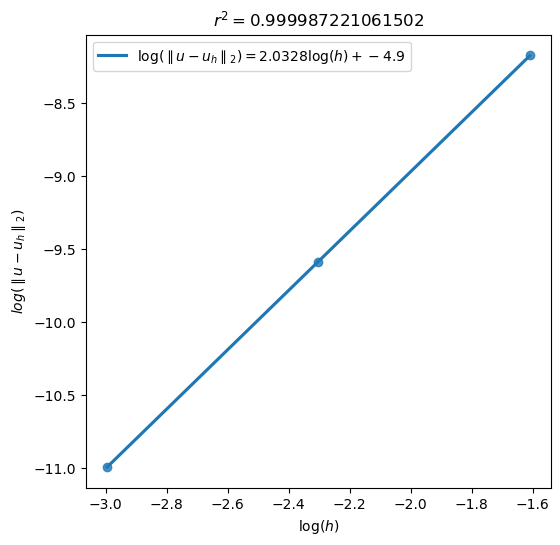

In [7]:
mesh_convergence(1)

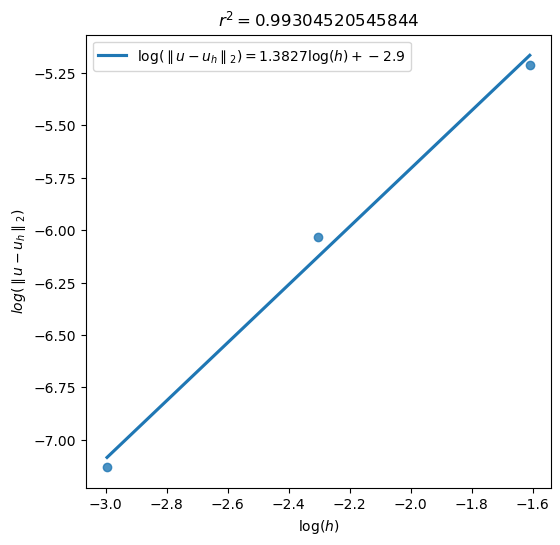

In [11]:
mesh_convergence(1e-3)

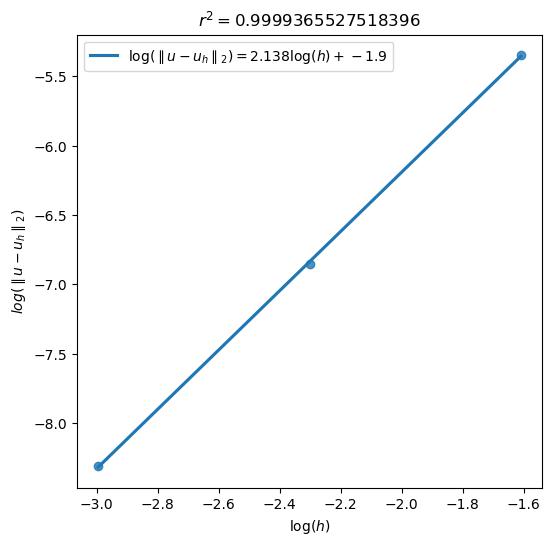

In [9]:
mesh_convergence(1e-6)